In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arnabbiswas1/microsoft-azure-predictive-maintenance")

print("Path to dataset files:", path)

/Users/miguelangellieramontano/Developer/o_repos/MAzure_Pred_Main/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/miguelangellieramontano/.cache/kagglehub/datasets/arnabbiswas1/microsoft-azure-predictive-maintenance/versions/3


In [2]:
# Standard library imports
import datetime

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Scikit-learn imports
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.preprocessing import MinMaxScaler


# EDA

`PdM_telemetry` shows the sensor readings for each machine; it can possibly help us generate an analysis to know when one of them might fail.

In [3]:
telemetry = pd.read_csv(f'{path}/PdM_telemetry.csv')
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [4]:
temp = pd.read_csv(f'{path}/PdM_telemetry.csv')
temp[temp['machineID']==1].shape

(8761, 6)

In [5]:
telemetry['machineID'].unique() #100 maquinas en total

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [6]:
# si hubo mantenimiento, puede haber sido programado o se debe a una falla
maint = pd.read_csv(f'{path}/PdM_maint.csv')
maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [7]:
errors = pd.read_csv(f'{path}/PdM_errors.csv')
errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [8]:
machines = pd.read_csv(f'{path}/PdM_machines.csv')
machines

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2
...,...,...,...
95,96,model2,10
96,97,model2,14
97,98,model2,20
98,99,model1,14


In [9]:
failures = pd.read_csv(f'{path}/PdM_failures.csv')
failures = failures.sort_values(by='datetime')
failures.reset_index(inplace=True, drop=True)
failures.head()

,datetime,machineID,failure
0,2015-01-02 03:00:00,56,comp3
1,2015-01-02 03:00:00,99,comp3
2,2015-01-02 03:00:00,83,comp4
3,2015-01-02 03:00:00,59,comp1
4,2015-01-02 03:00:00,16,comp1


In [10]:
telemetry[['volt', 'rotate', 'pressure', 'vibration']].describe()

,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000
mean,170.777736,446.605119,100.858668,40.385007
std,15.509114,52.673886,11.048679,5.370361
min,97.333604,138.432075,51.237106,14.877054
25%,160.304927,412.305714,93.498181,36.777299
50%,170.607338,447.558150,100.425559,40.237247
75%,181.004493,482.176600,107.555231,43.784938
max,255.124717,695.020984,185.951998,76.791072


In [11]:
machine_telemetry = machines.merge(telemetry, on=['machineID'], how='left')
machine_telemetry.head()

,machineID,model,age,datetime,volt,rotate,pressure,vibration
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686
1,1,model3,18,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973
2,1,model3,18,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847
3,1,model3,18,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144
4,1,model3,18,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511


In [12]:
telemetry_with_failure = machine_telemetry.merge(failures, on=['datetime', 'machineID'], how='left')
telemetry_with_failure.fillna('No Failure', inplace=True)
telemetry_with_failure.head()

,machineID,model,age,datetime,volt,rotate,pressure,vibration,failure
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,No Failure
1,1,model3,18,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,No Failure
2,1,model3,18,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,No Failure
3,1,model3,18,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,No Failure
4,1,model3,18,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,No Failure


In [13]:
telemetry_with_f_e = telemetry_with_failure.merge(errors, on=['datetime', 'machineID'], how='left')
telemetry_with_f_e.fillna('No Error', inplace=True)
telemetry_with_f_e.head()

,machineID,model,age,datetime,volt,rotate,pressure,vibration,failure,errorID
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,No Failure,No Error
1,1,model3,18,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,No Failure,No Error
2,1,model3,18,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,No Failure,No Error
3,1,model3,18,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,No Failure,No Error
4,1,model3,18,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,No Failure,No Error


In [14]:
telemetry_with_f_e = telemetry_with_f_e.merge(maint, on=['datetime', 'machineID'], how='left')
telemetry_with_f_e.fillna('No Maint', inplace=True)
telemetry_with_f_e.head()

,machineID,model,age,datetime,volt,rotate,pressure,vibration,failure,errorID,comp
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,No Failure,No Error,No Maint
1,1,model3,18,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,No Failure,No Error,No Maint
2,1,model3,18,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,No Failure,No Error,No Maint
3,1,model3,18,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,No Failure,No Error,No Maint
4,1,model3,18,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,No Failure,No Error,No Maint


In [15]:
telemetry_with_f_e.isnull().all()

machineID    False
model        False
age          False
datetime     False
volt         False
rotate       False
pressure     False
vibration    False
failure      False
errorID      False
comp         False
dtype: bool

In [16]:
def str_to_date(date_array, format):
    new_datetime = list()
    for date in date_array:
        new_datetime.append(datetime.datetime.strptime(date, format))
    return new_datetime

In [17]:
datetime_column = str_to_date(telemetry_with_f_e['datetime'], '%Y-%m-%d %H:%M:%S')

In [18]:
telemetry_with_f_e['datetime'] = datetime_column
telemetry_with_f_e['datetime'].min(), telemetry_with_f_e['datetime'].max()

(Timestamp('2015-01-01 06:00:00'), Timestamp('2016-01-01 06:00:00'))

# Hours to fail

One of the most important pieces of data is how much time remains before a machine experiences a failure. Based on this, we will try to analyze which characteristics of each record are useful for generating a time-based prediction.

In [19]:
def hours_estimation(machine_id):
    df: pd.DataFrame = telemetry_with_f_e[telemetry_with_f_e['machineID'] == machine_id]
    df.reset_index(drop=True, inplace=True)
    rul = []
    cont = len(df['failure']) - 1
    diff = 0
    while cont >= df.index.min():
        if df['failure'][cont] == 'No Failure':
            diff = diff + 1
            rul.append(diff)

        else:
            rul.append(0)
            diff = 0
        diff = rul[-1]
        cont = cont - 1
    df['hours_to_fail'] = list(reversed(rul))
    return df

In [20]:
dfs = []

machine_ids = np.arange(1, 101)
len(machine_ids)

for machine_id in machine_ids:
    df = hours_estimation(machine_id)
    dfs.append(df)

telemetry = pd.DataFrame()
for df in dfs:
    telemetry = pd.concat([telemetry, df], axis=0)

/var/folders/w_/21dg5vqn6gx3cbhxdn6pk8th0000gp/T/ipykernel_55385/3162706670.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hours_to_fail'] = list(reversed(rul))
/var/folders/w_/21dg5vqn6gx3cbhxdn6pk8th0000gp/T/ipykernel_55385/3162706670.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hours_to_fail'] = list(reversed(rul))
/var/folders/w_/21dg5vqn6gx3cbhxdn6pk8th0000gp/T/ipykernel_55385/3162706670.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [21]:
telemetry['Error'] = telemetry['errorID'].apply(lambda x: 0 if x=='No Error' else 1)
telemetry['Failure'] = telemetry['failure'].apply(lambda x: 0 if x=='No Failure' else 1)

In [22]:
telemetry['errors'] = telemetry.groupby(['machineID'])['Error'].cumsum()
telemetry['failures'] = telemetry.groupby(['machineID'])['Failure'].cumsum()

In [23]:
telemetry = telemetry.drop(columns=['Error', 'Failure'])
telemetry.head()

,machineID,model,age,datetime,volt,rotate,pressure,vibration,failure,errorID,comp,hours_to_fail,errors,failures
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,No Failure,No Error,No Maint,96,0,0
1,1,model3,18,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,No Failure,No Error,No Maint,95,0,0
2,1,model3,18,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,No Failure,No Error,No Maint,94,0,0
3,1,model3,18,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,No Failure,No Error,No Maint,93,0,0
4,1,model3,18,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,No Failure,No Error,No Maint,92,0,0


In [24]:
telemetry['maint'] = pd.factorize(telemetry['comp'])[0]
telemetry.drop(columns=['comp'])
telemetry

,machineID,model,age,datetime,volt,rotate,pressure,vibration,failure,errorID,comp,hours_to_fail,errors,failures,maint
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,No Failure,No Error,No Maint,96,0,0,0
1,1,model3,18,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,No Failure,No Error,No Maint,95,0,0,0
2,1,model3,18,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,No Failure,No Error,No Maint,94,0,0,0
3,1,model3,18,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,No Failure,No Error,No Maint,93,0,0,0
4,1,model3,18,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,No Failure,No Error,No Maint,92,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8761,100,model4,5,2016-01-01 02:00:00,179.438162,395.222827,102.290715,50.771941,No Failure,No Error,No Maint,5,31,3,0
8762,100,model4,5,2016-01-01 03:00:00,189.617555,446.207972,98.180607,35.123072,No Failure,No Error,No Maint,4,31,3,0
8763,100,model4,5,2016-01-01 04:00:00,192.483414,447.816524,94.132837,48.314561,No Failure,No Error,No Maint,3,31,3,0
8764,100,model4,5,2016-01-01 05:00:00,165.475310,413.771670,104.081073,44.835259,No Failure,No Error,No Maint,2,31,3,0


In [25]:
telemetry['seconds_to_fail'] = telemetry['hours_to_fail'] * 3600
telemetry.drop('hours_to_fail', axis=1, inplace=True)
telemetry.head()

,machineID,model,age,datetime,volt,rotate,pressure,vibration,failure,errorID,comp,errors,failures,maint,seconds_to_fail
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,No Failure,No Error,No Maint,0,0,0,345600
1,1,model3,18,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,No Failure,No Error,No Maint,0,0,0,342000
2,1,model3,18,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,No Failure,No Error,No Maint,0,0,0,338400
3,1,model3,18,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,No Failure,No Error,No Maint,0,0,0,334800
4,1,model3,18,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,No Failure,No Error,No Maint,0,0,0,331200


## Correlation Analysis Summary (Heatmap Interpretation)

This correlation heatmap displays the **Pearson correlation matrix** between various machine features, including `age`, `datetime`, `volt`, `rotate`, `pressure`, `vibration`, `errors`, `failures`, `maint`, and the target variable, `seconds_to_fail`. Pearson correlation values range from -1 (perfect negative correlation) to 1 (perfect positive correlation), with 0 indicating no linear correlation.

### Key Observations Regarding `seconds_to_fail` (Time Remaining Until Failure):

Our primary focus is the `seconds_to_fail` column, representing the remaining operational time before a machine failure.

* **Weak Negative Correlations with `age` (-0.19) and `datetime` (-0.17):** As the machine `age` or the `datetime` progresses, the `seconds_to_fail` tends to decrease. This is logical: older machines or those further along in their operational timeline are naturally closer to experiencing a failure. The weak strength suggests these factors alone are not dominant predictors.
* **Weak to Moderate Negative Correlations with `errors` (-0.20) and `failures` (-0.22):** These are among the strongest (in absolute terms) linear correlations with our target variable. A higher count of `errors` and the occurrence of `failures` are associated with a reduced `seconds_to_fail`. This aligns with intuition, as errors often precede, and failures directly consume, remaining operational time.
* **Correlation with `maint` (-0.01):** Maintenance (`maint`) shows virtually no linear correlation with `seconds_to_fail`. This could indicate that the recorded maintenance is primarily reactive (post-failure) rather than preventive, or that the current maintenance strategy/data doesn't linearly influence the time until the next failure.
* **Sensor Readings (`volt`, `rotate`, `pressure`, `vibration`) exhibit very low correlations:** These critical sensor characteristics show near-zero linear correlations with `seconds_to_fail`, `errors`, and `failures`.

### Project Implications:

While `failures`, `errors`, `age`, and `datetime` appear to be the most linearly correlated features with `seconds_to_fail`, their correlations are only weak to moderate. The low linear correlation of sensor readings necessitates a deeper investigation into non-linear relationships or advanced feature engineering to fully leverage their potential for accurate time-to-failure prediction.

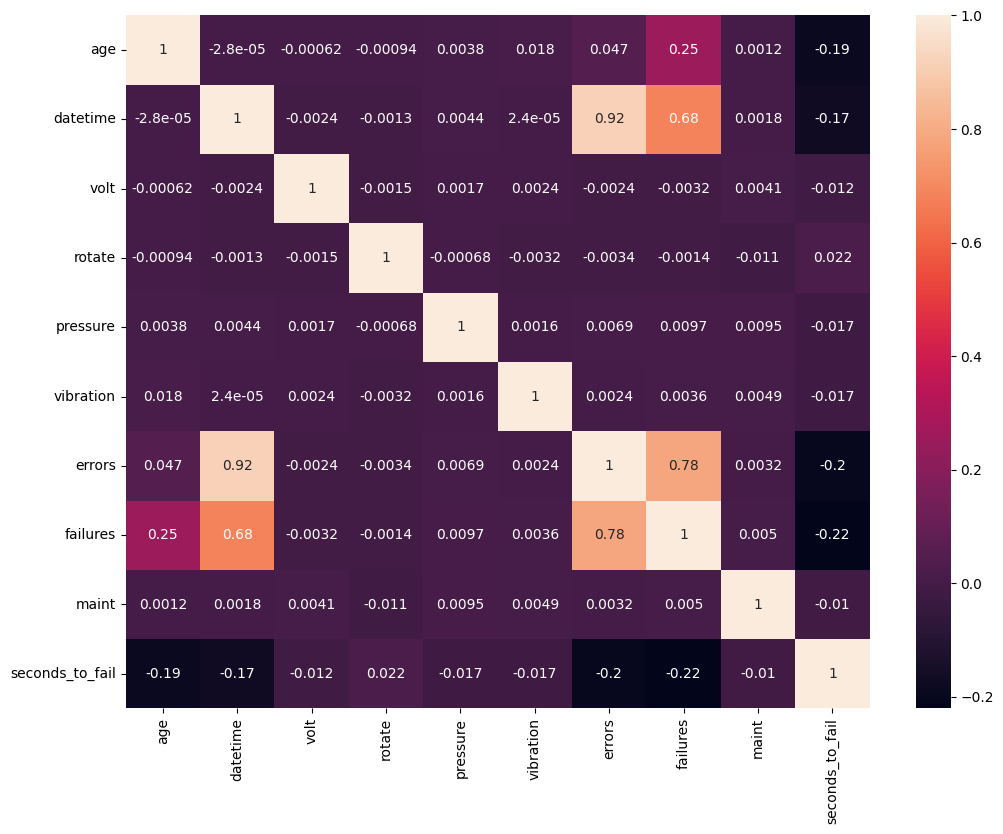

In [26]:
sns.heatmap(telemetry.drop(['machineID', 'model', 'failure', 'errorID', 'comp'], axis = 1).corr(), annot=True).figure.set_size_inches(12, 9)

In [27]:
datetimes = telemetry['datetime']
timestamps = list()
for datetime_ in datetimes:
    timestamps.append(datetime.datetime.timestamp(datetime_))    
datetimes.shape[0], len(timestamps)
telemetry['timestamp'] = timestamps
telemetry.head()

,machineID,model,age,datetime,volt,rotate,pressure,vibration,failure,errorID,comp,errors,failures,maint,seconds_to_fail,timestamp
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,No Failure,No Error,No Maint,0,0,0,345600,1.420114e+09
1,1,model3,18,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,No Failure,No Error,No Maint,0,0,0,342000,1.420117e+09
2,1,model3,18,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,No Failure,No Error,No Maint,0,0,0,338400,1.420121e+09
3,1,model3,18,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,No Failure,No Error,No Maint,0,0,0,334800,1.420124e+09
4,1,model3,18,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,No Failure,No Error,No Maint,0,0,0,331200,1.420128e+09


In [28]:
def create_time_step(data, machine_id):
    machine_id_data = data[data['machineID'] == machine_id]
    time_step = np.arange(1, machine_id_data.shape[0]+1)
    machine_id_data['time_step'] = time_step
    return machine_id_data

machineIDs = telemetry['machineID'].unique()
dataframes_with_time_step = []
for machine_id in machineIDs:
    dataframes_with_time_step.append(create_time_step(telemetry, machine_id))
len(dataframes_with_time_step)

/var/folders/w_/21dg5vqn6gx3cbhxdn6pk8th0000gp/T/ipykernel_55385/545078963.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_id_data['time_step'] = time_step
/var/folders/w_/21dg5vqn6gx3cbhxdn6pk8th0000gp/T/ipykernel_55385/545078963.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_id_data['time_step'] = time_step
/var/folders/w_/21dg5vqn6gx3cbhxdn6pk8th0000gp/T/ipykernel_55385/545078963.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

100

In [29]:
telemetry = pd.DataFrame()
for df in dataframes_with_time_step:
    telemetry = pd.concat([telemetry, df])

telemetry.sort_values(by=['datetime'], inplace=True)
telemetry.reset_index(drop=True, inplace=True)
telemetry.head()

,machineID,model,age,datetime,volt,rotate,pressure,vibration,failure,errorID,comp,errors,failures,maint,seconds_to_fail,timestamp,time_step
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,No Failure,No Error,No Maint,0,0,0,345600,1.420114e+09,1
1,55,model3,17,2015-01-01 06:00:00,147.044702,409.767331,102.826869,29.985309,No Failure,No Error,No Maint,0,0,0,5619600,1.420114e+09,1
2,54,model2,10,2015-01-01 06:00:00,158.865540,463.154857,90.765206,40.675116,No Failure,No Error,No Maint,0,0,0,1209600,1.420114e+09,1
3,79,model3,14,2015-01-01 06:00:00,194.167651,535.302327,84.071434,35.654640,No Failure,No Error,No Maint,0,0,0,75600,1.420114e+09,1
4,99,model1,14,2015-01-01 06:00:00,168.596133,384.747105,110.921131,41.944692,No Failure,No Error,No Maint,0,0,0,75600,1.420114e+09,1


In [30]:
telemetry.drop(columns=['model', 'failure', 'errorID', 'comp', 'datetime', 'timestamp'], inplace=True)
telemetry.head()

,machineID,age,volt,rotate,pressure,vibration,errors,failures,maint,seconds_to_fail,time_step
0,1,18,176.217853,418.504078,113.077935,45.087686,0,0,0,345600,1
1,55,17,147.044702,409.767331,102.826869,29.985309,0,0,0,5619600,1
2,54,10,158.865540,463.154857,90.765206,40.675116,0,0,0,1209600,1
3,79,14,194.167651,535.302327,84.071434,35.654640,0,0,0,75600,1
4,99,14,168.596133,384.747105,110.921131,41.944692,0,0,0,75600,1


# Data normalization

In [31]:
cols = list(telemetry.columns)
cols[9] = 'time_step'
cols[10] = 'seconds_to_fail'
telemetry = telemetry[cols]
telemetry

,machineID,age,volt,rotate,pressure,vibration,errors,failures,maint,time_step,seconds_to_fail
0,1,18,176.217853,418.504078,113.077935,45.087686,0,0,0,1,345600
1,55,17,147.044702,409.767331,102.826869,29.985309,0,0,0,1,5619600
2,54,10,158.865540,463.154857,90.765206,40.675116,0,0,0,1,1209600
3,79,14,194.167651,535.302327,84.071434,35.654640,0,0,0,1,75600
4,99,14,168.596133,384.747105,110.921131,41.944692,0,0,0,1,75600
...,...,...,...,...,...,...,...,...,...,...,...
877204,40,4,169.568080,455.595648,105.065630,34.255772,42,14,0,8772,3600
877205,39,0,178.480041,424.870644,79.234831,34.504028,37,8,0,8773,3600
877206,38,15,140.426314,481.873972,89.826135,38.081556,42,10,0,8772,3600
877207,37,16,192.417601,460.501263,101.107201,39.044452,43,19,0,8773,3600


In [32]:
n_telemetry = telemetry.copy(True) #8761, 10
# data_machine_x = data_machine_x.drop(['machineID'], axis=1)
n_machine = n_telemetry['machineID'].copy(deep=True)
n_telemetry.drop(columns=['machineID'], inplace=True)
n_telemetry


,age,volt,rotate,pressure,vibration,errors,failures,maint,time_step,seconds_to_fail
0,18,176.217853,418.504078,113.077935,45.087686,0,0,0,1,345600
1,17,147.044702,409.767331,102.826869,29.985309,0,0,0,1,5619600
2,10,158.865540,463.154857,90.765206,40.675116,0,0,0,1,1209600
3,14,194.167651,535.302327,84.071434,35.654640,0,0,0,1,75600
4,14,168.596133,384.747105,110.921131,41.944692,0,0,0,1,75600
...,...,...,...,...,...,...,...,...,...,...
877204,4,169.568080,455.595648,105.065630,34.255772,42,14,0,8772,3600
877205,0,178.480041,424.870644,79.234831,34.504028,37,8,0,8773,3600
877206,15,140.426314,481.873972,89.826135,38.081556,42,10,0,8772,3600
877207,16,192.417601,460.501263,101.107201,39.044452,43,19,0,8773,3600


In [33]:
scaler = MinMaxScaler(feature_range=(0,1))
n_telemetry = scaler.fit_transform(n_telemetry)
cols = list(telemetry.columns)[1:]
n_telemetry = pd.DataFrame(n_telemetry, columns=cols)
n_telemetry.insert(0,'machineID',n_machine)
n_telemetry

,machineID,age,volt,rotate,pressure,vibration,errors,failures,maint,time_step,seconds_to_fail
0,1,0.90,0.499928,0.503194,0.459050,0.487945,0.000000,0.000000,0.0,0.000000,0.010944
1,55,0.85,0.315044,0.487497,0.382955,0.244020,0.000000,0.000000,0.0,0.000000,0.177953
2,54,0.50,0.389958,0.583416,0.293420,0.416676,0.000000,0.000000,0.0,0.000000,0.038304
3,79,0.70,0.613685,0.713040,0.243732,0.335588,0.000000,0.000000,0.0,0.000000,0.002394
4,99,0.70,0.451626,0.442544,0.443040,0.437181,0.000000,0.000000,0.0,0.000000,0.002394
...,...,...,...,...,...,...,...,...,...,...,...
877204,40,0.20,0.457785,0.569835,0.399574,0.312994,0.700000,0.538462,0.0,0.998975,0.000114
877205,39,0.00,0.514265,0.514632,0.207829,0.317004,0.616667,0.307692,0.0,0.999089,0.000114
877206,38,0.75,0.273100,0.617048,0.286450,0.374786,0.700000,0.384615,0.0,0.998975,0.000114
877207,37,0.80,0.602594,0.578648,0.370190,0.390338,0.716667,0.730769,0.0,0.999089,0.000114


In [34]:
def createXY(dataset: np.ndarray,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
        dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
        dataY.append(dataset[i,-1])
    dataY = np.array(dataY)
    dataY.reshape((dataY.shape[0],1))
    return np.array(dataX), dataY

In [35]:
def data_per_machine(x, data_set, test=False):
    X_data_per_machine = {}
    y_data_per_machine = {}
    in_ = 71 if test else 1
    out_ = 70 + x if test else x
    for i in range(in_, out_+1):
        data_machine_x: pd.DataFrame = data_set[data_set["machineID"] == i] #8761, 10
        data_machine_x = data_machine_x.drop(['machineID'], axis=1)
        X, y = createXY(data_machine_x.to_numpy(), 5)
        X_data_per_machine[i] = X
        y_data_per_machine[i] = y
    return X_data_per_machine, y_data_per_machine


# Model creation

# Keras Sequential LSTM Model Description

This is a **Sequential Keras model** designed for **time series prediction** (predicting a single value, the seconds to fail metric). It leverages a **stacked Long Short-Term Memory (LSTM)** architecture, which is highly effective for learning patterns and dependencies in sequential data.

---

## Model Architecture Breakdown

### 1. `Sequential` Model

The model is constructed using Keras's `Sequential` API, meaning that layers are added one after another in a linear stack. This approach provides a straightforward and common method for building neural networks.

### 2. Stacked LSTM Layers

* **First LSTM Layer:**
    * `LSTM(15, activation='tanh', return_sequences=True, input_shape=(5,1))`
    * This is the initial LSTM layer, featuring **15 memory units (neurons)**.
    * It employs the **hyperbolic tangent (`tanh`) activation function**.

* **Second LSTM Layer:**
    * `LSTM(10, activation='tanh')`
    * This is the second LSTM layer, which receives the sequential output from the first LSTM layer as its input. It comprises **10 memory units**.
    * It also utilizes the `tanh` activation function.

### 3. `Dropout` Layer

* `Dropout(0.2)`
* This layer serves as a **regularization technique**.

### 4. `Dense` Output Layer

* `Dense(1)`
* This is a standard **fully connected layer** containing **1 neuron**. This single neuron typically generates the ultimate predicted value.
---

In [36]:
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.optimizers import Adam
from keras import Sequential
from keras import models

opt = Adam(learning_rate=0.001)
model=Sequential()
model.add(LSTM(15,activation='tanh', return_sequences=True ,input_shape=(5,1)))
model.add(LSTM(10,activation='tanh' ))

model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer=opt, loss = "mse")

/Users/miguelangellieramontano/Developer/o_repos/MAzure_Pred_Main/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [37]:
n_telemetry

,machineID,age,volt,rotate,pressure,vibration,errors,failures,maint,time_step,seconds_to_fail
0,1,0.90,0.499928,0.503194,0.459050,0.487945,0.000000,0.000000,0.0,0.000000,0.010944
1,55,0.85,0.315044,0.487497,0.382955,0.244020,0.000000,0.000000,0.0,0.000000,0.177953
2,54,0.50,0.389958,0.583416,0.293420,0.416676,0.000000,0.000000,0.0,0.000000,0.038304
3,79,0.70,0.613685,0.713040,0.243732,0.335588,0.000000,0.000000,0.0,0.000000,0.002394
4,99,0.70,0.451626,0.442544,0.443040,0.437181,0.000000,0.000000,0.0,0.000000,0.002394
...,...,...,...,...,...,...,...,...,...,...,...
877204,40,0.20,0.457785,0.569835,0.399574,0.312994,0.700000,0.538462,0.0,0.998975,0.000114
877205,39,0.00,0.514265,0.514632,0.207829,0.317004,0.616667,0.307692,0.0,0.999089,0.000114
877206,38,0.75,0.273100,0.617048,0.286450,0.374786,0.700000,0.384615,0.0,0.998975,0.000114
877207,37,0.80,0.602594,0.578648,0.370190,0.390338,0.716667,0.730769,0.0,0.999089,0.000114


In [38]:
n_telemetry = n_telemetry.drop(columns=['age', 'time_step', 'errors', 'failures', 'maint', 'volt', 'rotate', 'pressure', 'vibration'])

In [39]:
Results=pd.DataFrame()
N_MACHINES_TRAIN = 10
EPOCHS = 1
trainX, trainY = data_per_machine(N_MACHINES_TRAIN, n_telemetry)

for i in tqdm(range(1, EPOCHS)):
    for i in range(1,N_MACHINES_TRAIN+1):
        print("Iteration #",i)
            
        history=model.fit(trainX[i], trainY[i], epochs = 100, batch_size=100, validation_split=.2, verbose=0)
        Results["Machine",i] = history.history["loss"]

0it [00:00, ?it/s]


In [40]:
# model.save(f'models/LSTM/e{EPOCHS}_m{N_MACHINES_TRAIN}_lstmv3.keras')
model = models.load_model('models/LSTM/e3_m70_lstmv3.keras')

In [41]:
N_MACHINES_TEST = 30
test_x, test_y = data_per_machine(N_MACHINES_TEST, n_telemetry, test=True)


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step
(8768, 1)


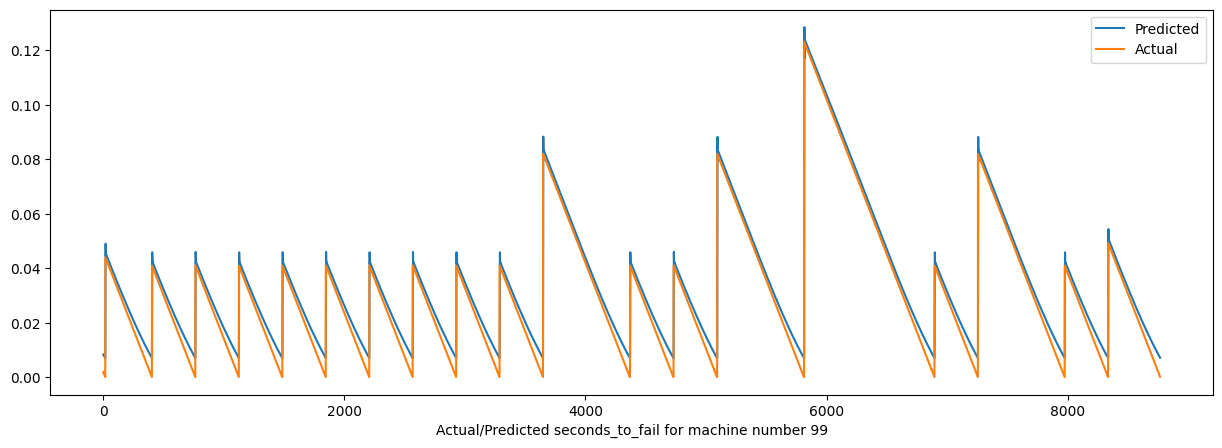

In [52]:
MACHINE = 99
y_pred = model.predict(test_x[MACHINE])

print(y_pred.shape)

plt.figure(figsize=(15 , 5))
plt.plot(y_pred,label='Predicted')
plt.plot(test_y[MACHINE],label='Actual')
plt.xlabel(f"Actual/Predicted seconds_to_fail for machine number {MACHINE}")
plt.legend()
plt.show()

In [43]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_y[MACHINE], y_pred)
print(f"MSE: {mse}")

MSE: 1.759496421447839e-05


In [44]:
temp_array =np.zeros((y_pred.shape[0], scaler.n_features_in_))
temp_array[:, -1] = y_pred.flatten()
u_y_pred = scaler.inverse_transform(temp_array)

In [45]:
u_y_pred[0]

array([0.00000000e+00, 9.73336038e+01, 1.38432075e+02, 5.12371058e+01,
       1.48770540e+01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 2.62120267e+05])

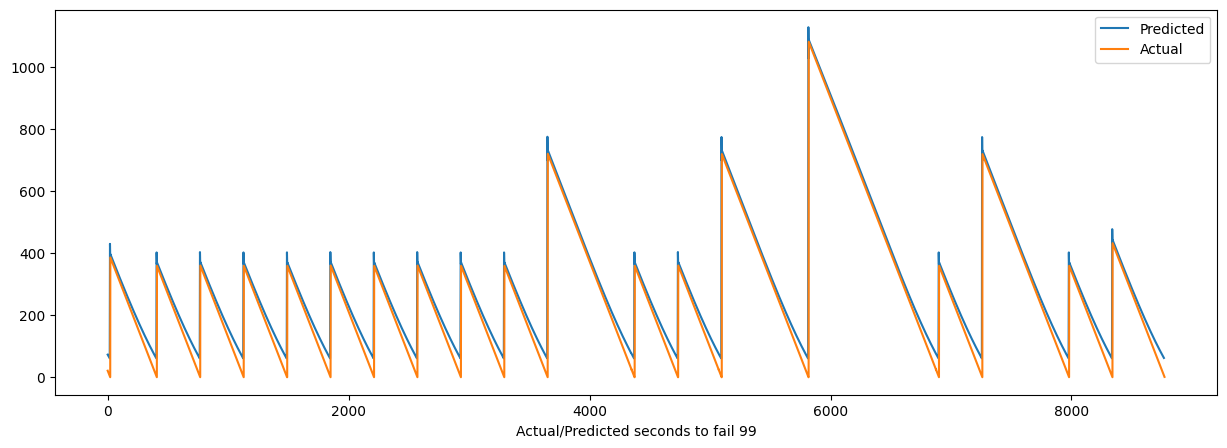

MSE: 2829.1904383380947
MAE: 26.240463506566382


In [46]:
machine_x_stf = telemetry[telemetry['machineID'] == MACHINE].seconds_to_fail.to_numpy()
plt.figure(figsize=(15 , 5))
plt.plot(u_y_pred[:,-1]/3600,label='Predicted')
plt.plot(machine_x_stf/3600,label='Actual')
plt.xlabel(f"Actual/Predicted seconds to fail {MACHINE}")
plt.legend()
plt.show()

mse = mean_squared_error(machine_x_stf[:8768]/3600, u_y_pred[:,-1]/3600)
print(f"MSE: {mse}")
mae = mean_absolute_error(machine_x_stf[:8768]/3600, u_y_pred[:,-1]/3600)
print(f"MAE: {mae}")

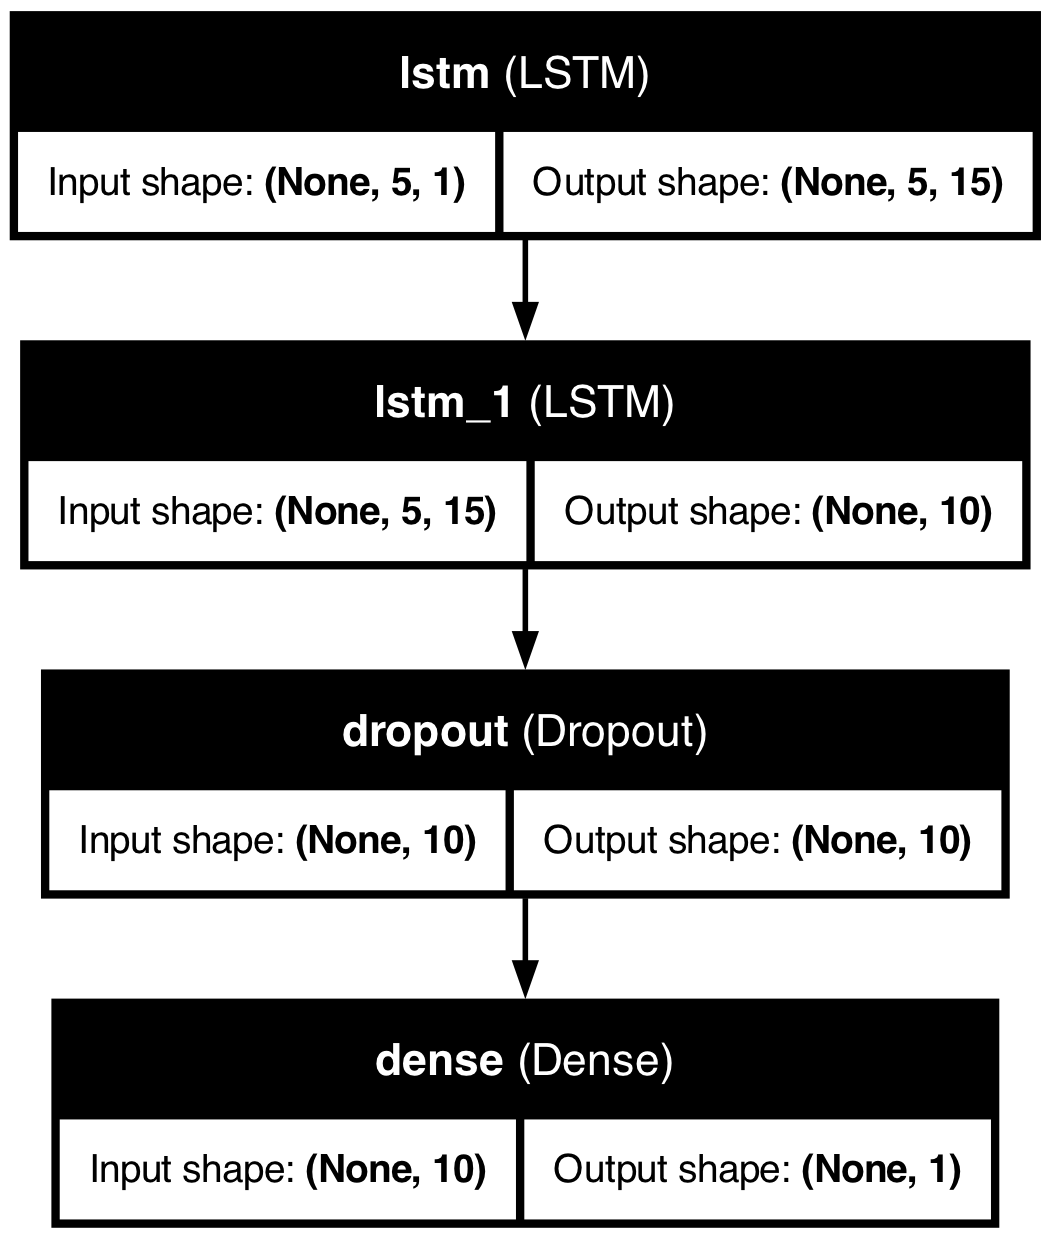

In [51]:

from keras.utils import plot_model
plot_model(model, to_file='images/lstmv3.png', show_shapes=True, show_layer_names=True)